In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Timestamp

from tensorflow.keras import Sequential
from keras.layers import Dense, GRU, Dropout
from tensorflow.keras.layers import LeakyReLU

import warnings
warnings.filterwarnings('ignore')

In [2]:
sectors_data = {}
excel_file_path = 'logreturns_2000_2020_data_by_sector.xlsx'
snp_price_data = pd.ExcelFile(excel_file_path)
for sheet_name in snp_price_data.sheet_names:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    sheet_data['Date'] = pd.to_datetime(sheet_data['Unnamed: 0'], format='%Y-%m-%d')
    sheet_data.set_index('Date', inplace=True)
    sheet_data.drop(columns='Unnamed: 0', inplace=True)
    sectors_data[sheet_name] = sheet_data

# 데이터프레임 생성
df = pd.DataFrame()
for sector, data in sectors_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

df = df[1:]

In [58]:
#스케일링을 위한 학습데이터와 테스트데이터 셋 분리
train_scaling_size = int(len(df) * 0.7)
t_train_X = df[0 : train_scaling_size]
t_train_y = df[0 : train_scaling_size]


# 전체 데이터 중 최소값과 최대값 구하기
tot_train_min = np.minimum.reduce([t_train_X.min(axis=0), t_train_X.min(axis=0)])
tot_train_max = np.maximum.reduce([t_train_X.max(axis=0), t_train_X.max(axis=0)])

# 각 주식의 범위를 계산
train_range = tot_train_max - tot_train_min

In [59]:
import pandas as pd

end_date = pd.Timestamp('2020-12-31')
one_month = pd.DateOffset(months=1)
sixty_days = pd.DateOffset(days=60)

data_X = []
data_y = []
start_day_idx = [] # data_X를 생성하기 위한 매달 시작일 인덱스 리스트

# data_y부터 생성
start_date = pd.Timestamp('2000-04-01')

while start_date < end_date:
    end_of_period = start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    selected_data = df[(df.index >= start_date) & (df.index <= end_of_period)]

    indexing = df.index.get_loc(selected_data.index[0])

    # 각 주식에 대한 월별 평균 수익률 계산
    average_values = selected_data.mean(axis=0)

    data_y.append(average_values)
    start_day_idx.append(indexing)
    start_date = start_date + pd.DateOffset(months=1)  # Move to next month

start_date = pd.Timestamp('2000-01-01')

i = 0
while i < len(data_y):
    index_day_start = start_day_idx[i]

    nearest_index = None
    for j in range(index_day_start - 1, index_day_start - 61, -1):
        if j < 0:
            break
        if df.index[j] in df.index:
            nearest_index = j
            break

    if nearest_index is not None:
        sixty_day_data = df.iloc[nearest_index - 60 : nearest_index]
        data_X.append(sixty_day_data)
    else:
        pass

    i += 1

In [60]:
#학습데이터와 테스트데이터 셋 분리
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

# #테스트데이터는 전체 데이터로~
# test_X = np.array(data_X)
# test_y = np.array(data_y)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (174, 60, 55) (174, 55)
테스트 데이터의 크기 : (75, 60, 55) (75, 55)


In [61]:
# 스케일링
train_X = (train_X - tot_train_min) / (train_range + 1e-7)
train_y = (train_y - tot_train_min) / (train_range + 1e-7)
test_X = (test_X - tot_train_min) / (train_range + 1e-7)
test_y = (test_y - tot_train_min) / (train_range + 1e-7)

In [62]:
# 각 행을 60번 반복 복붙
repeat_train_y = np.repeat(train_y, repeats=60, axis=0)
repeat_test_y = np.repeat(test_y, repeats=60, axis=0)

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 55개의 주식에 대한 55개의 모델을 저장할 리스트
models = []
predictions = []
rmses = []

for i in range(55):  # 55개 주식에 대해 반복
    model = LinearRegression()
    # 각 주식에 대한 수익률을 종속 변수로 사용하여 모델 훈련
    train_X_reshaped = train_X.reshape(-1, 55)
    model.fit(train_X_reshaped, repeat_train_y[:, i])
    # 저장
    models.append(model)

    # 테스트 데이터로 예측
    test_X_reshaped = test_X.reshape(-1, 55)
    prediction = model.predict(test_X_reshaped)
    predictions.append(prediction)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(repeat_test_y[:, i], prediction))
    rmses.append(rmse)

# 각 주식에 대한 모델의 성능을 출력
for i, rmse in enumerate(rmses):
    print(f"주식 {i+1}에 대한 Test RMSE: {rmse}")

predictions = np.array(predictions).T

predictions_reshaped = predictions.reshape(75, 60 ,55)
predictions_means = predictions_reshaped.mean(axis=1)

주식 1에 대한 Test RMSE: 0.00886909432871776
주식 2에 대한 Test RMSE: 0.010079972336504579
주식 3에 대한 Test RMSE: 0.00871340047503843
주식 4에 대한 Test RMSE: 0.00826017988639493
주식 5에 대한 Test RMSE: 0.01001600391798151
주식 6에 대한 Test RMSE: 0.006980171430823533
주식 7에 대한 Test RMSE: 0.005841253735938281
주식 8에 대한 Test RMSE: 0.010220859218446697
주식 9에 대한 Test RMSE: 0.00809285993273489
주식 10에 대한 Test RMSE: 0.007685766127077427
주식 11에 대한 Test RMSE: 0.011744197610958287
주식 12에 대한 Test RMSE: 0.011324533217643373
주식 13에 대한 Test RMSE: 0.017523243375531145
주식 14에 대한 Test RMSE: 0.016101026666979934
주식 15에 대한 Test RMSE: 0.01786103147174134
주식 16에 대한 Test RMSE: 0.007632438096891391
주식 17에 대한 Test RMSE: 0.012847434501266746
주식 18에 대한 Test RMSE: 0.005319543533075287
주식 19에 대한 Test RMSE: 0.005619630677729442
주식 20에 대한 Test RMSE: 0.009618944843876967
주식 21에 대한 Test RMSE: 0.016451538377223365
주식 22에 대한 Test RMSE: 0.013371935991970106
주식 23에 대한 Test RMSE: 0.01324321095839607
주식 24에 대한 Test RMSE: 0.006036289586757489
주식 25에 대

In [64]:
test_y = test_y * (train_range + 1e-7) + tot_train_min
pred_y = predictions_means * (train_range + 1e-7) + tot_train_min

In [72]:
# Assuming predictions is a NumPy array
column_names = [f'Prediction_{i}' for i in range(pred_y.shape[1])]
predictions_df = pd.DataFrame(pred_y, columns=column_names)

# Save predictions to an Excel file
predictions_df.to_excel('LR_predictions_logreturns.xlsx', index=False)

In [71]:
import matplotlib.pyplot as plt

stocks = {
        'Tele' : ['VZ', 'DIS', 'T', 'CMCSA', 'EA'],
        'COND' : ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX'],
        'ENRG': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
        'HLCA' : ['JNJ', 'PFE', 'UNH','MRK','ABT'],
        'INDS' : ['BA', 'MMM','UNP','HON','RTX'],
        'MTRS': ['PPG', 'APD', 'ECL', 'SHW', 'NEM'],
        'FINC' : ['JPM', 'BRK-B', 'BAC', 'WFC', 'C'],
        'CONS' : ['PG', 'KO', 'PEP','WMT','MO'],
        'INFT' : ['AAPL','MSFT','INTC','CSCO','ORCL'],
        'UTIL' : ['NEE','DUK','D','SO','EXC'],
        'REES' : ['AMT', 'SPG', 'CCI', 'PLD', 'PSA']
    }



# 각 주식에 대한 그래프 그리기 위해 회사 리스트 생성
company_list = []
for sector in stocks:
    company_list += stocks[sector]

plt.rcParams['font.size'] = 20


# 각 주식 별 예측값&실제값 그래프 그리기
for i, company in enumerate(company_list):
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    # plt.plot(test_y[:,i], color='blue', label='Actual Stock Price of ' + company)

    # 예측 데이터 그래프
    plt.plot(pred_y[:,i], color='red', label='Predicted Stock Price of ' + company)

    plt.title('Stock Price Prediction of ' + company)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

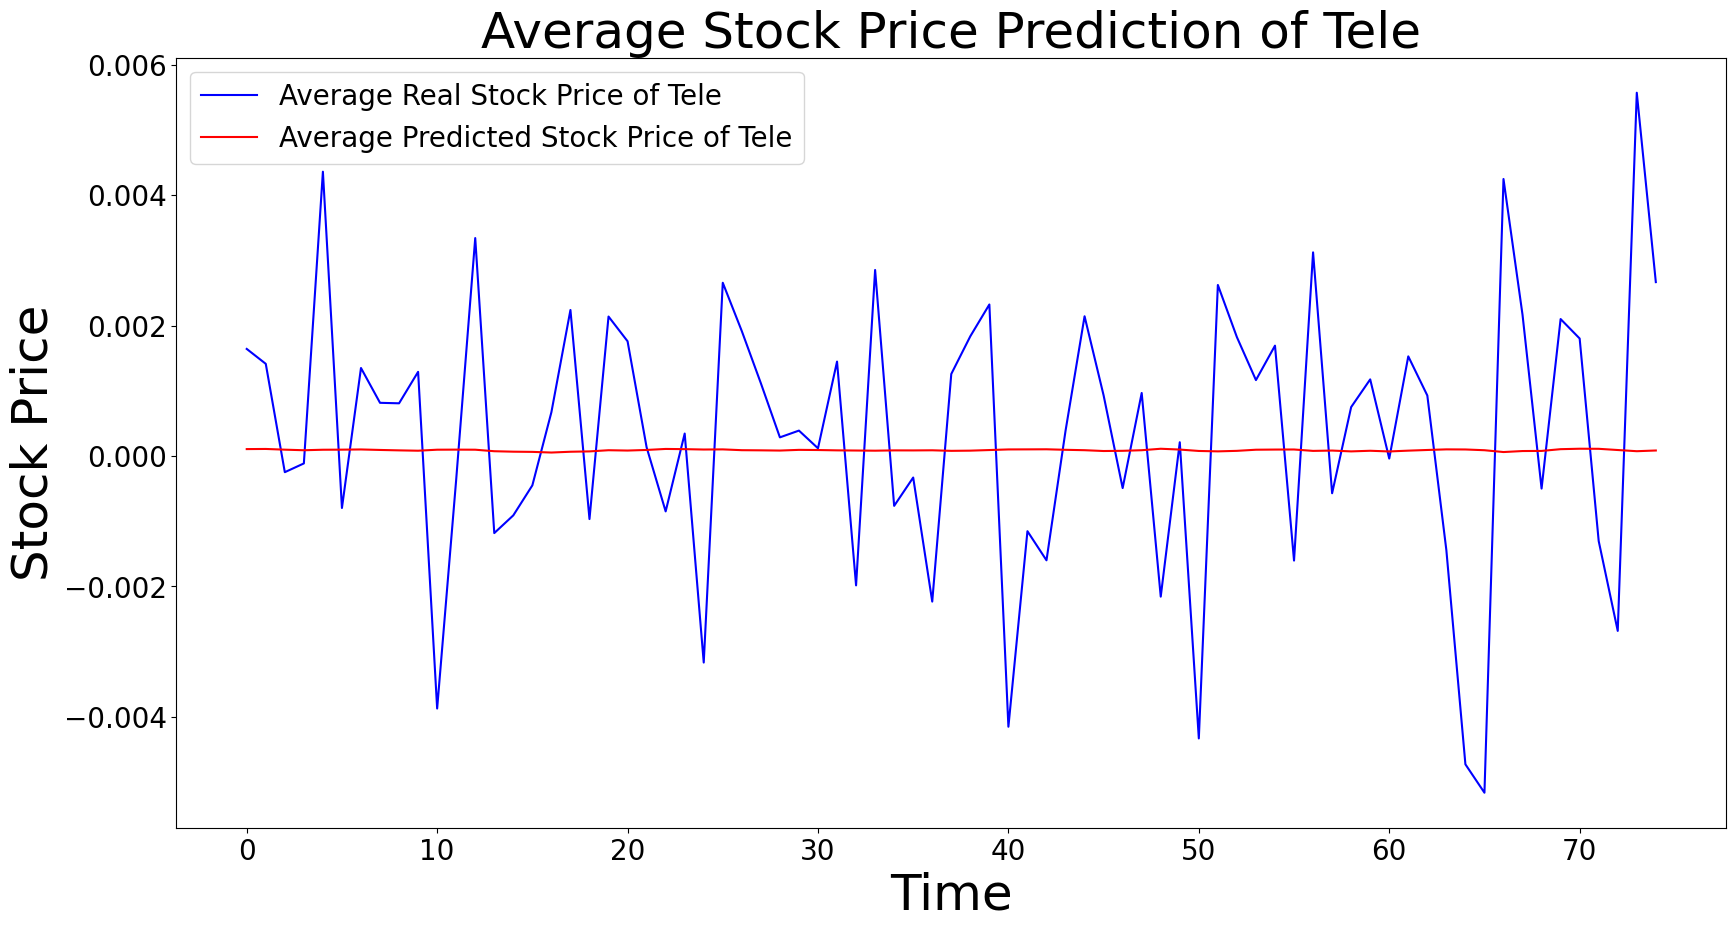

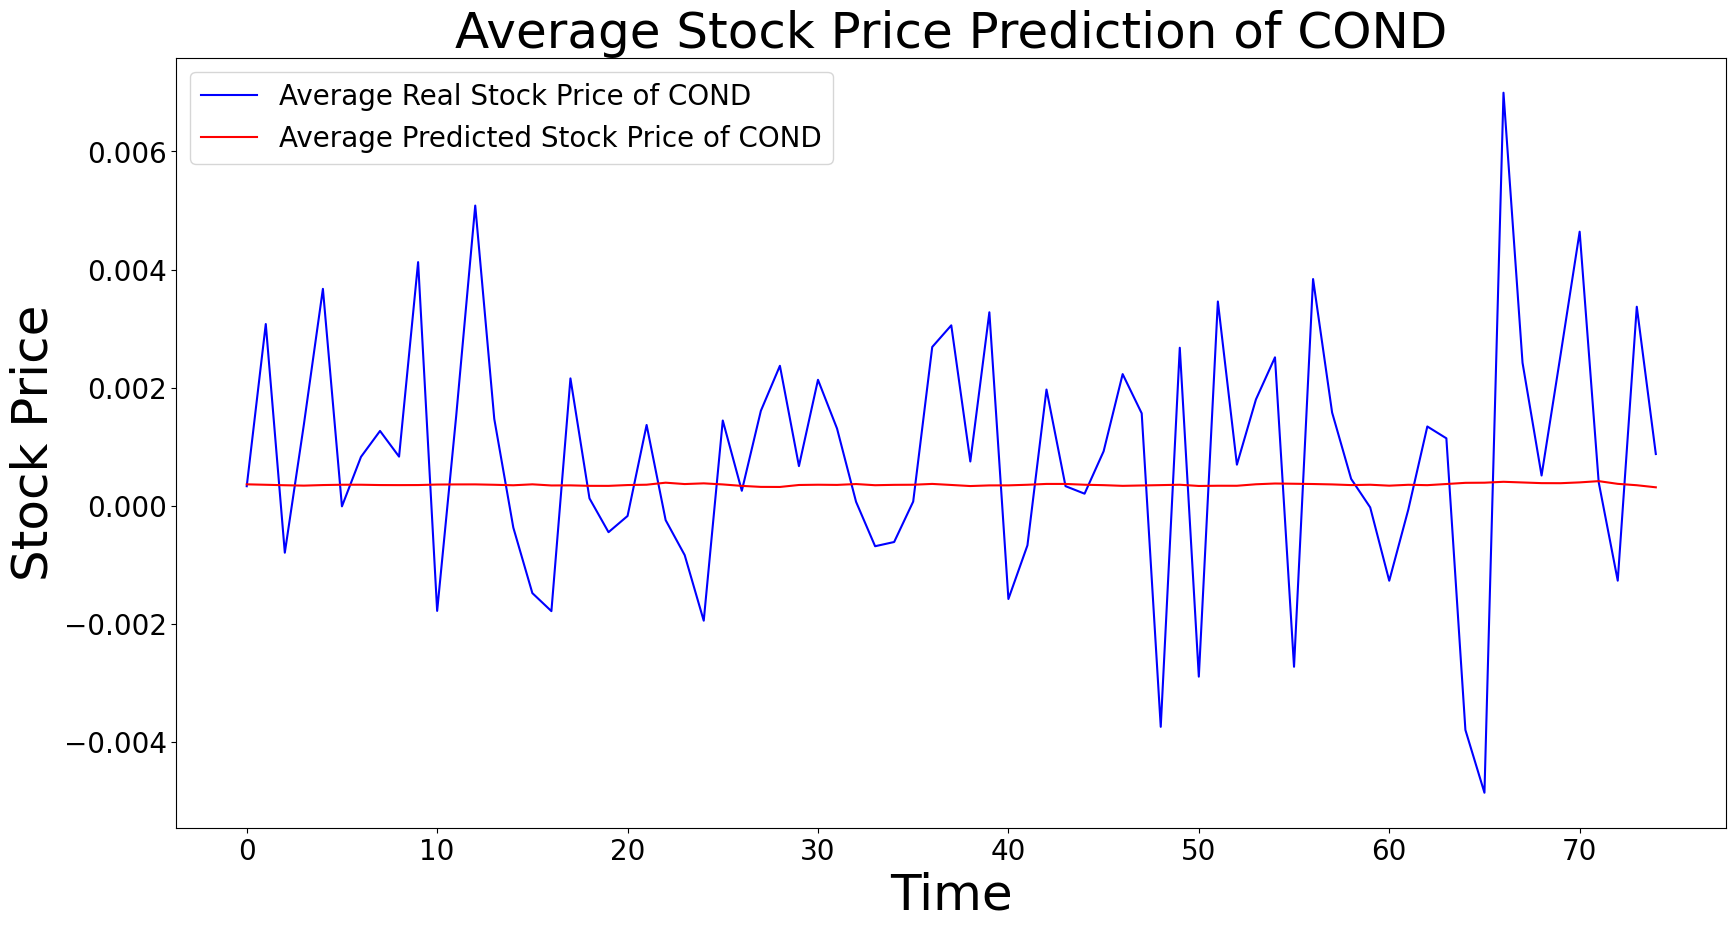

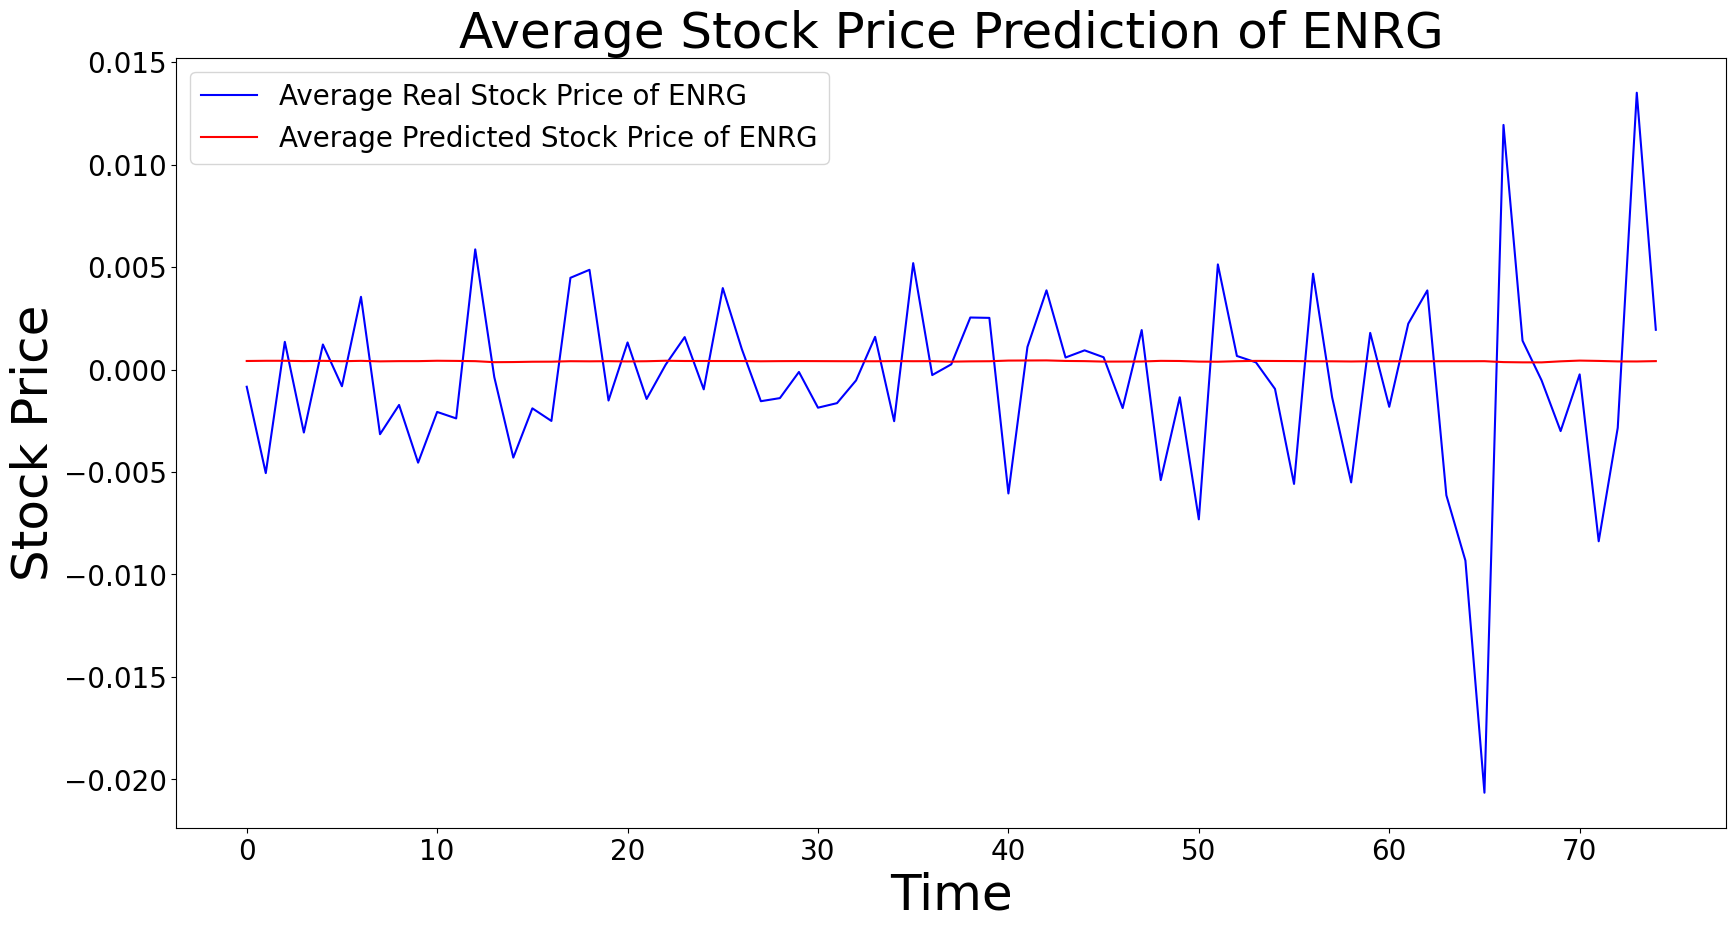

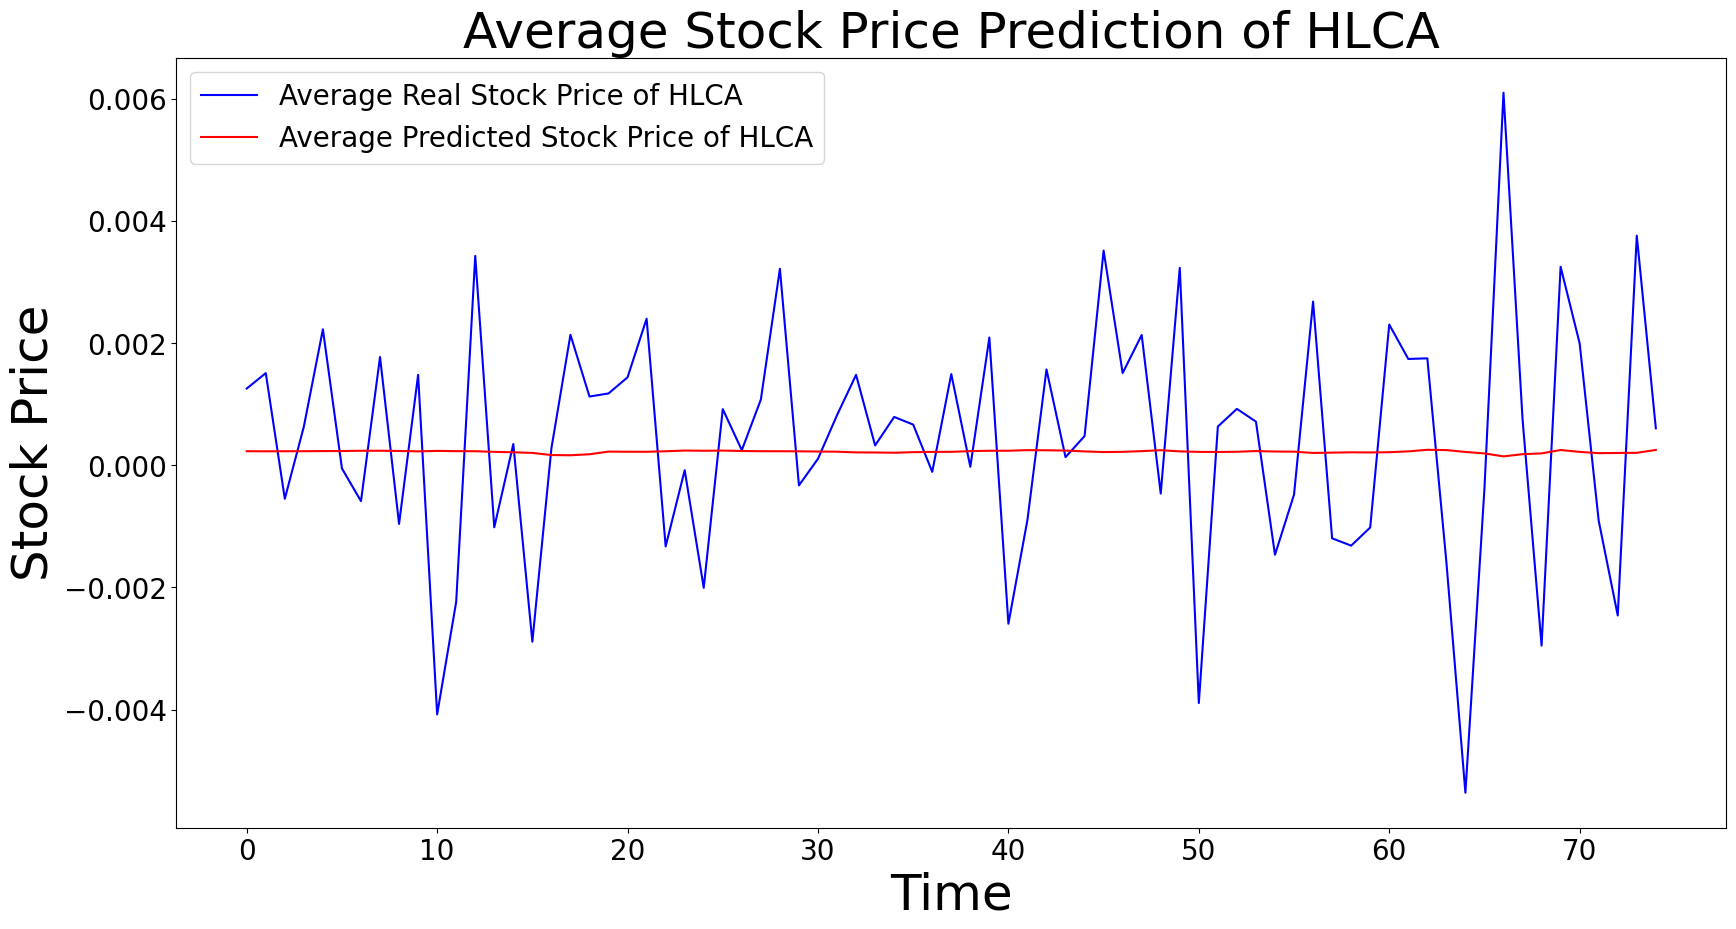

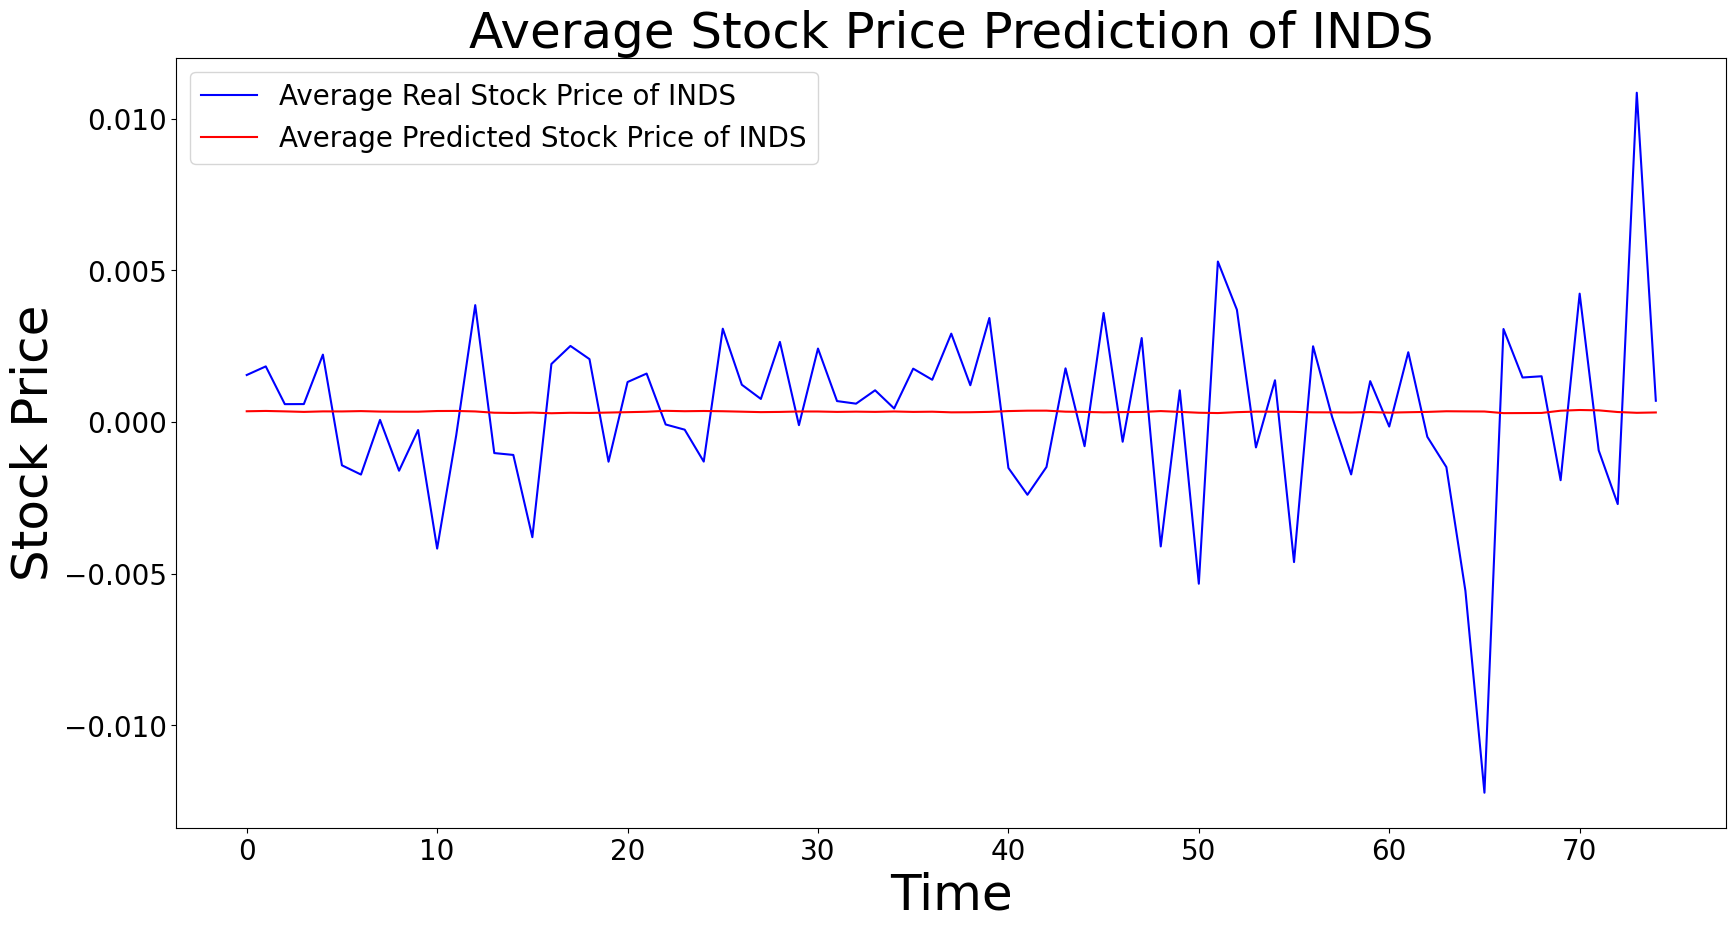

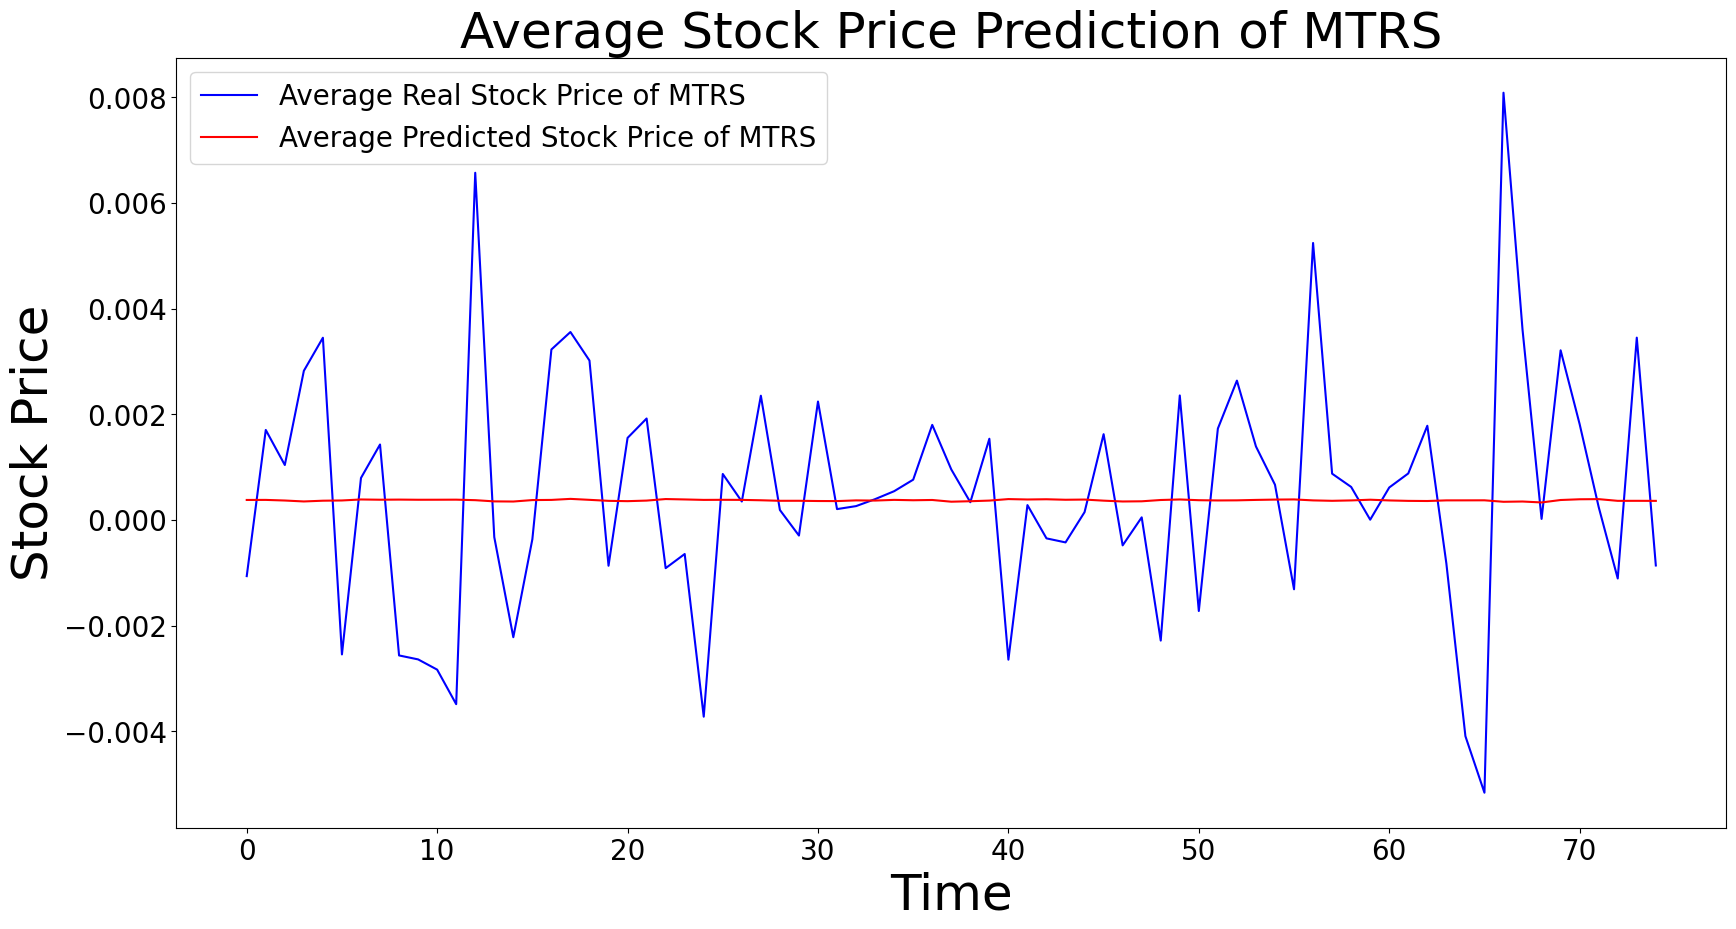

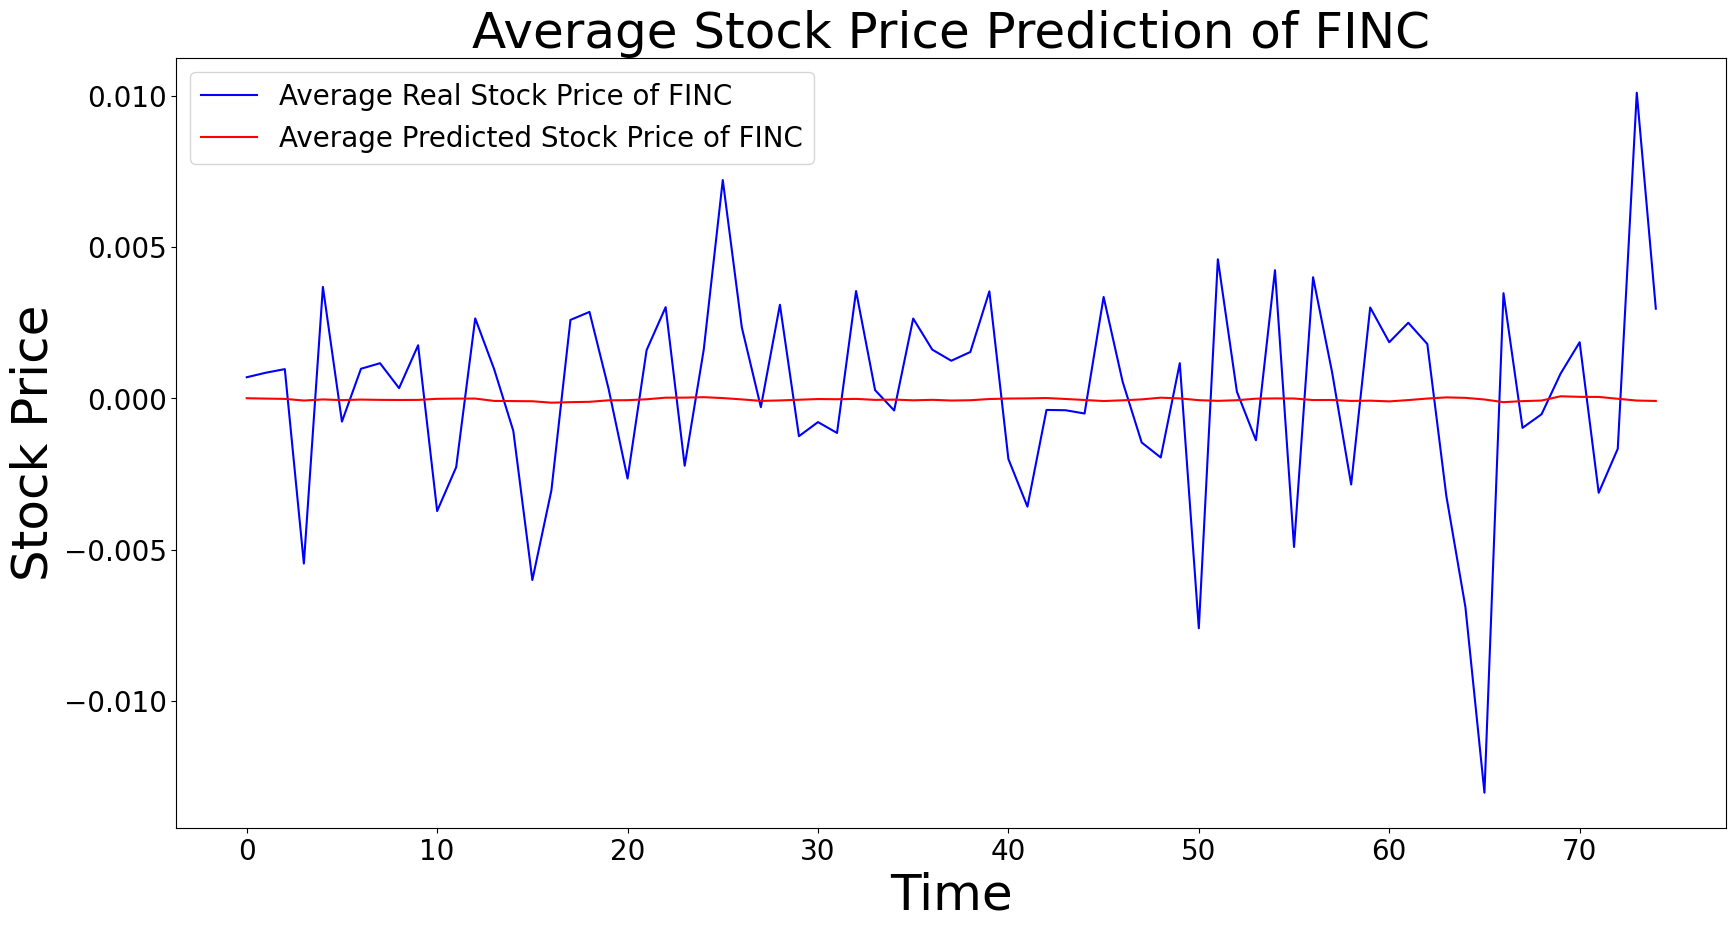

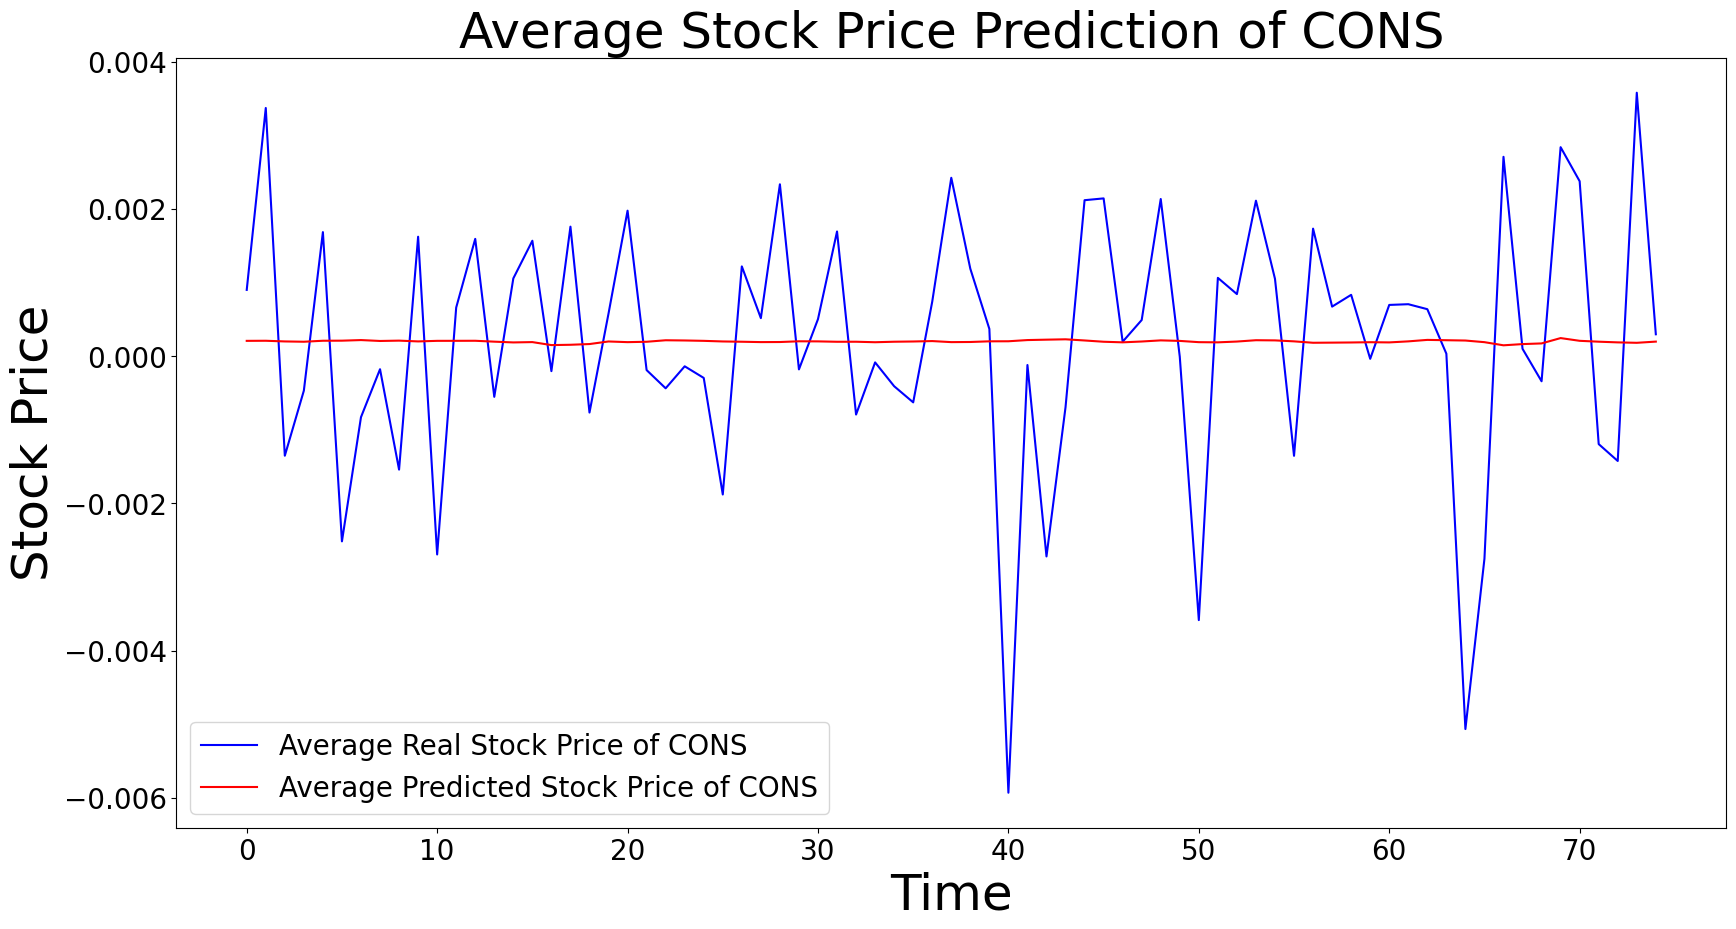

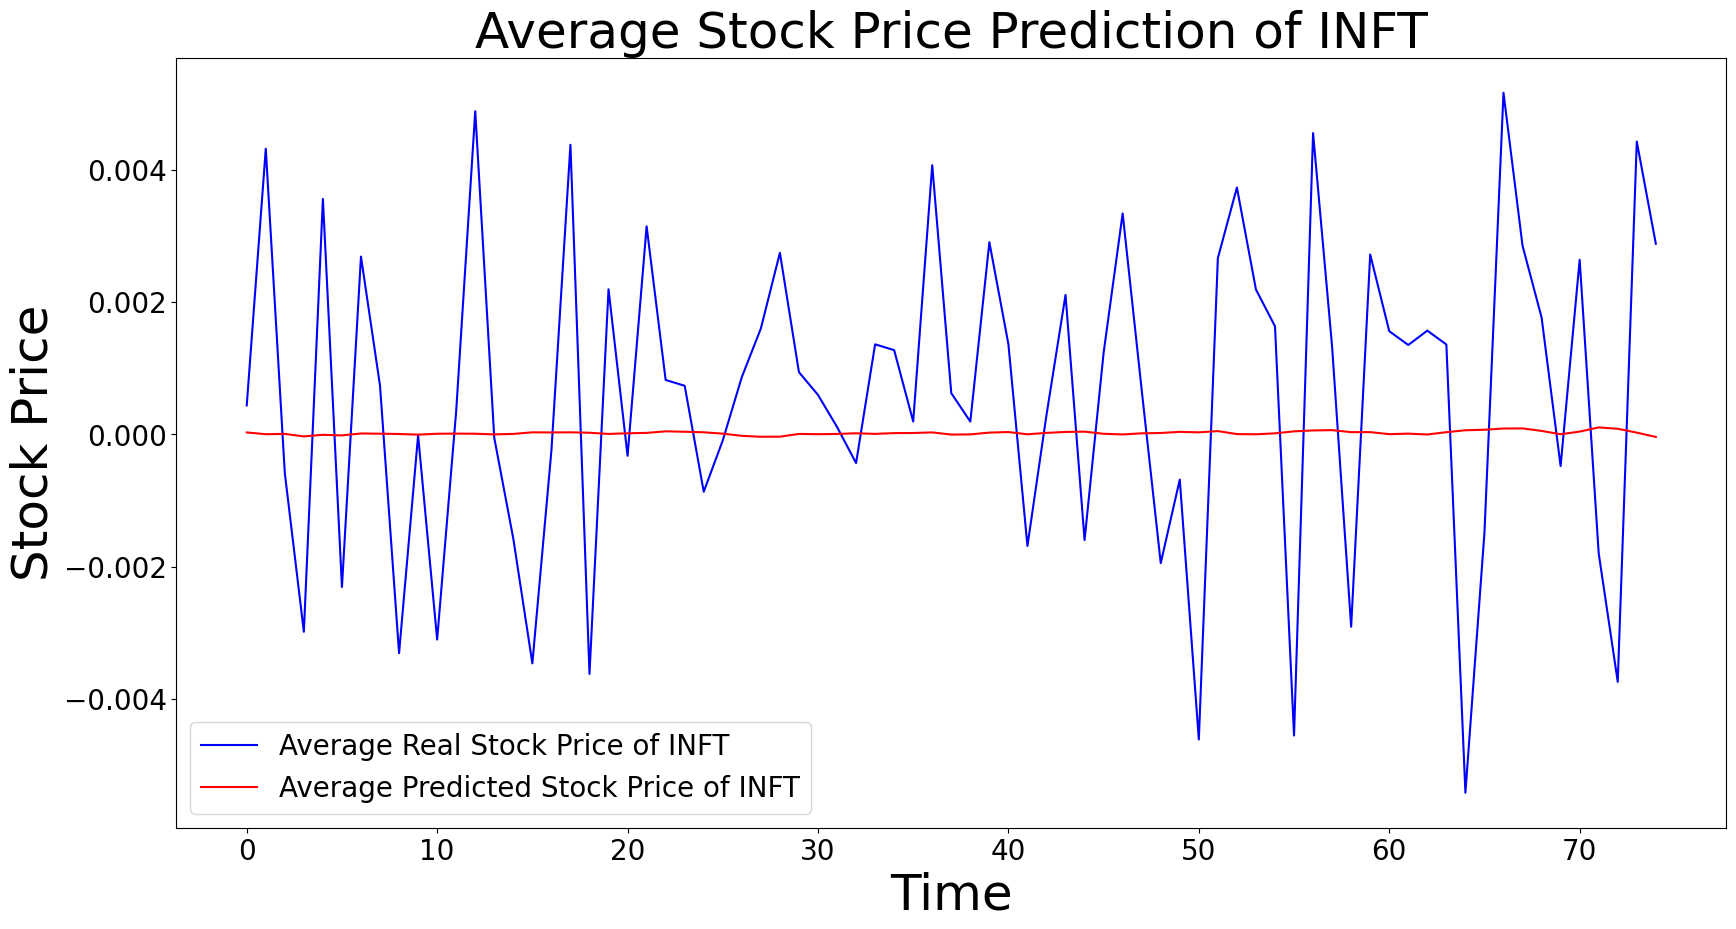

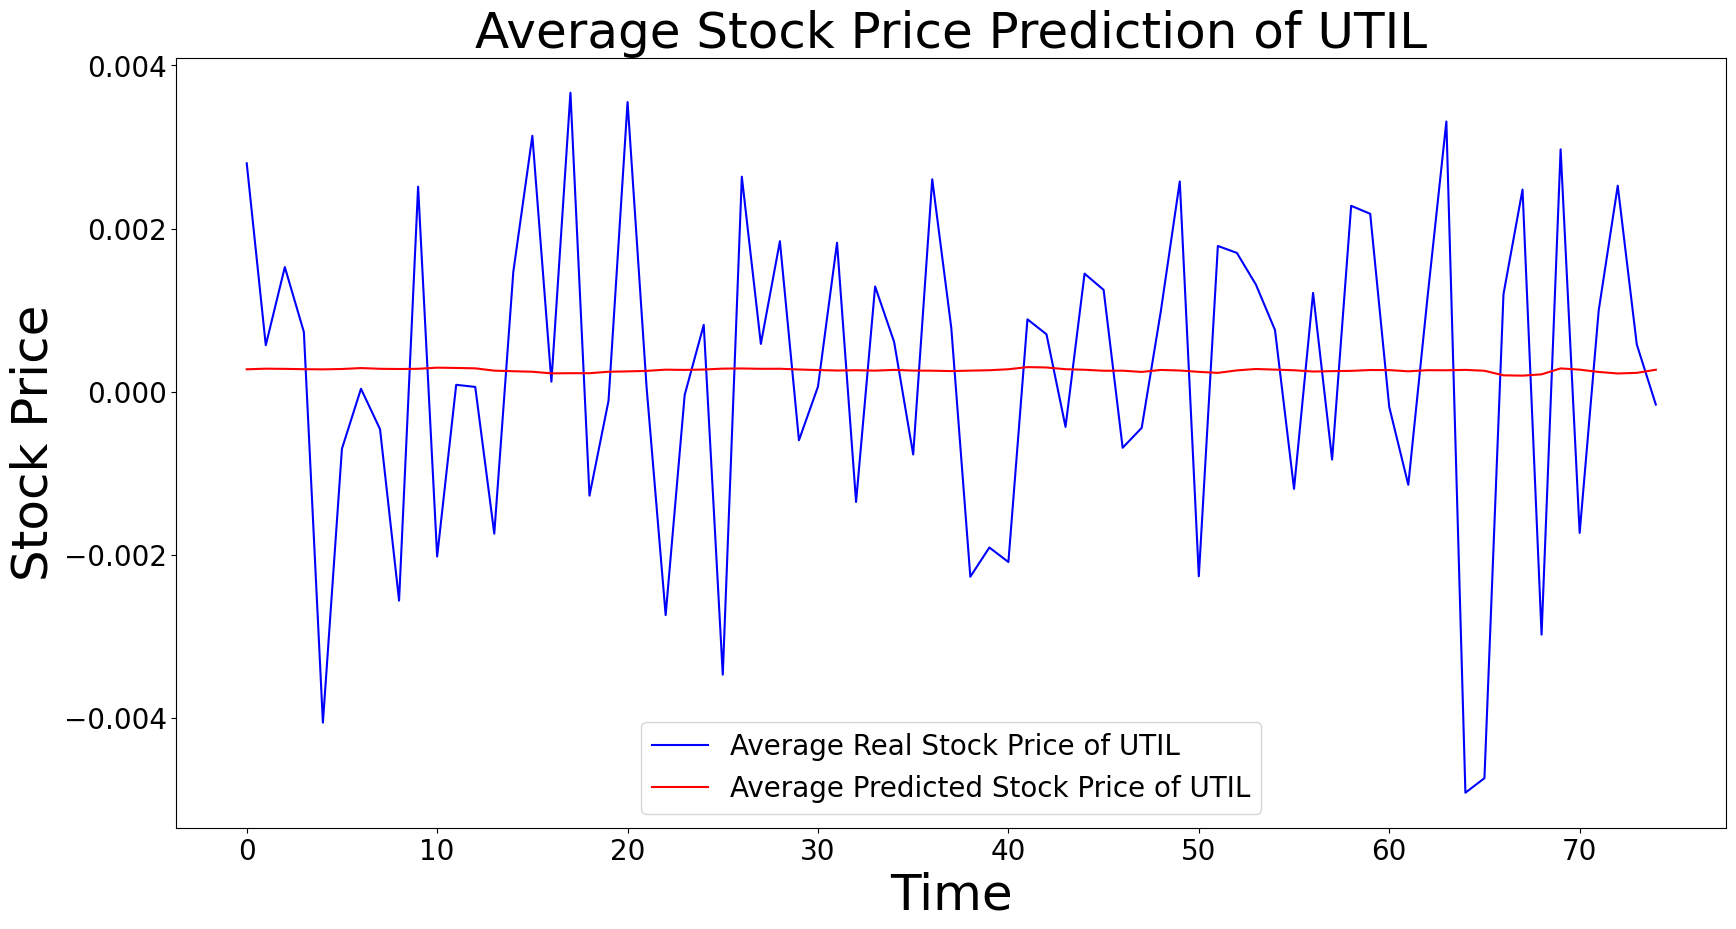

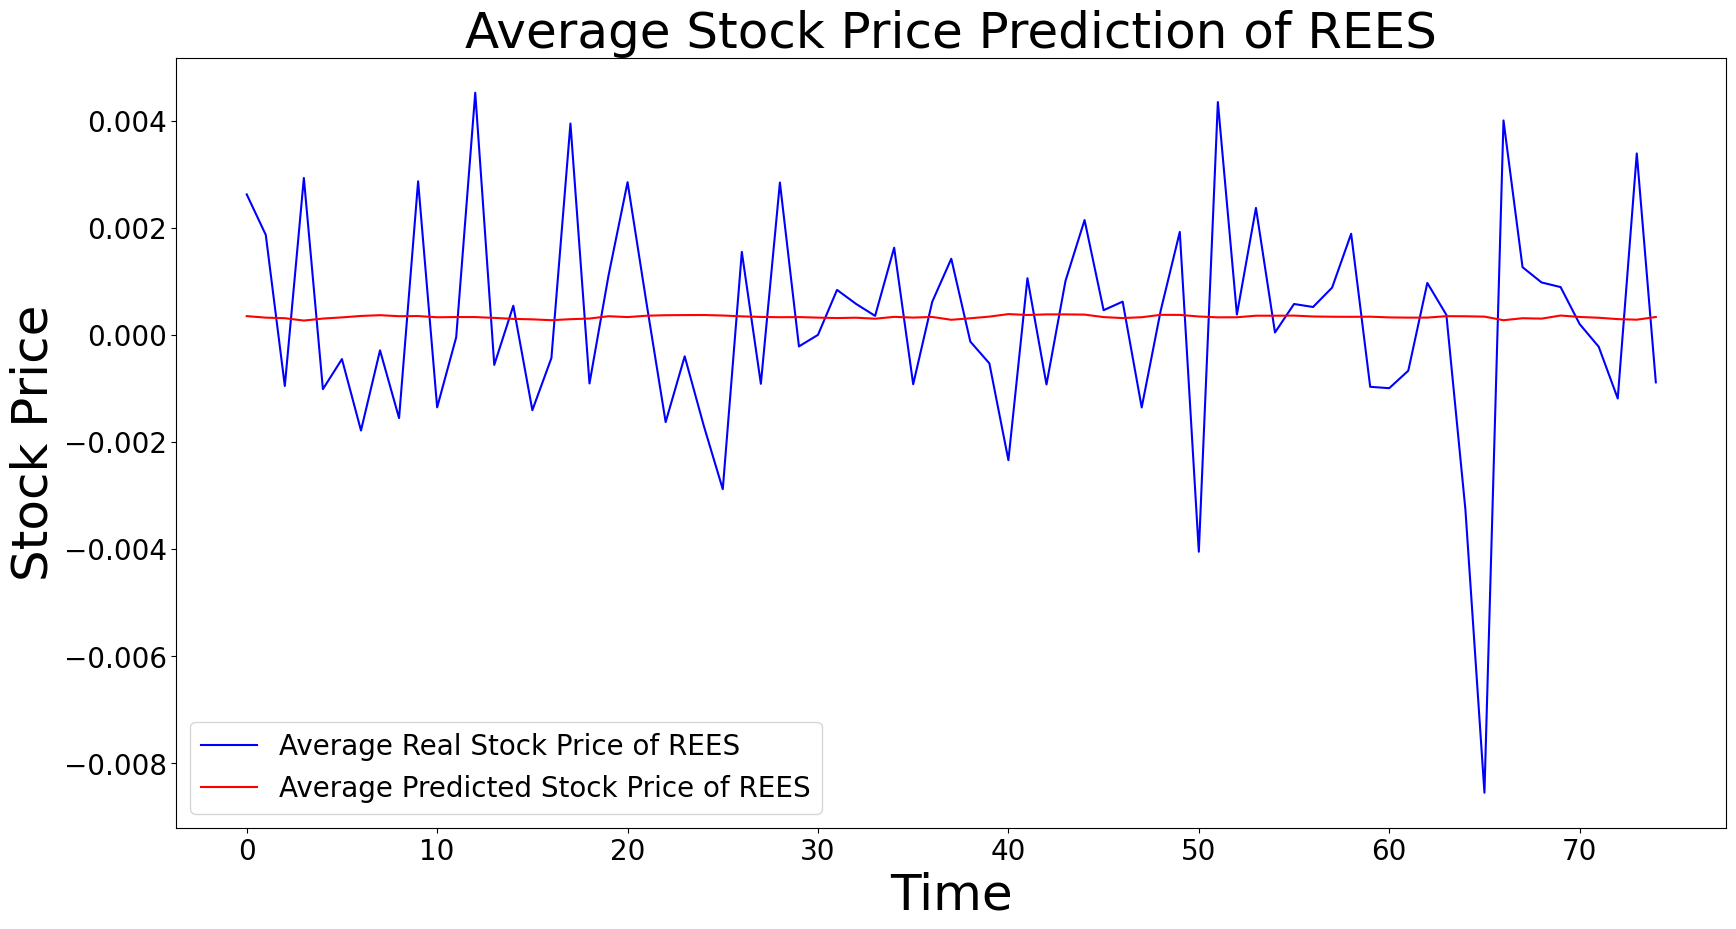

In [70]:
# 각 섹터별 예측값&실제값 그래프 그리기

plt.rcParams['font.size'] = 20

for sector in stocks:
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    avg_test_y = np.mean([test_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_test_y, color='blue', label='Average Real Stock Price of ' + sector)

    # 예측 데이터 그래프
    avg_pred_y = np.mean([pred_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price of ' + sector)

    plt.title('Average Stock Price Prediction of ' + sector, fontsize=36)
    plt.xlabel('Time', fontsize=36)
    plt.ylabel('Stock Price', fontsize=36)
    plt.legend()
    plt.show()


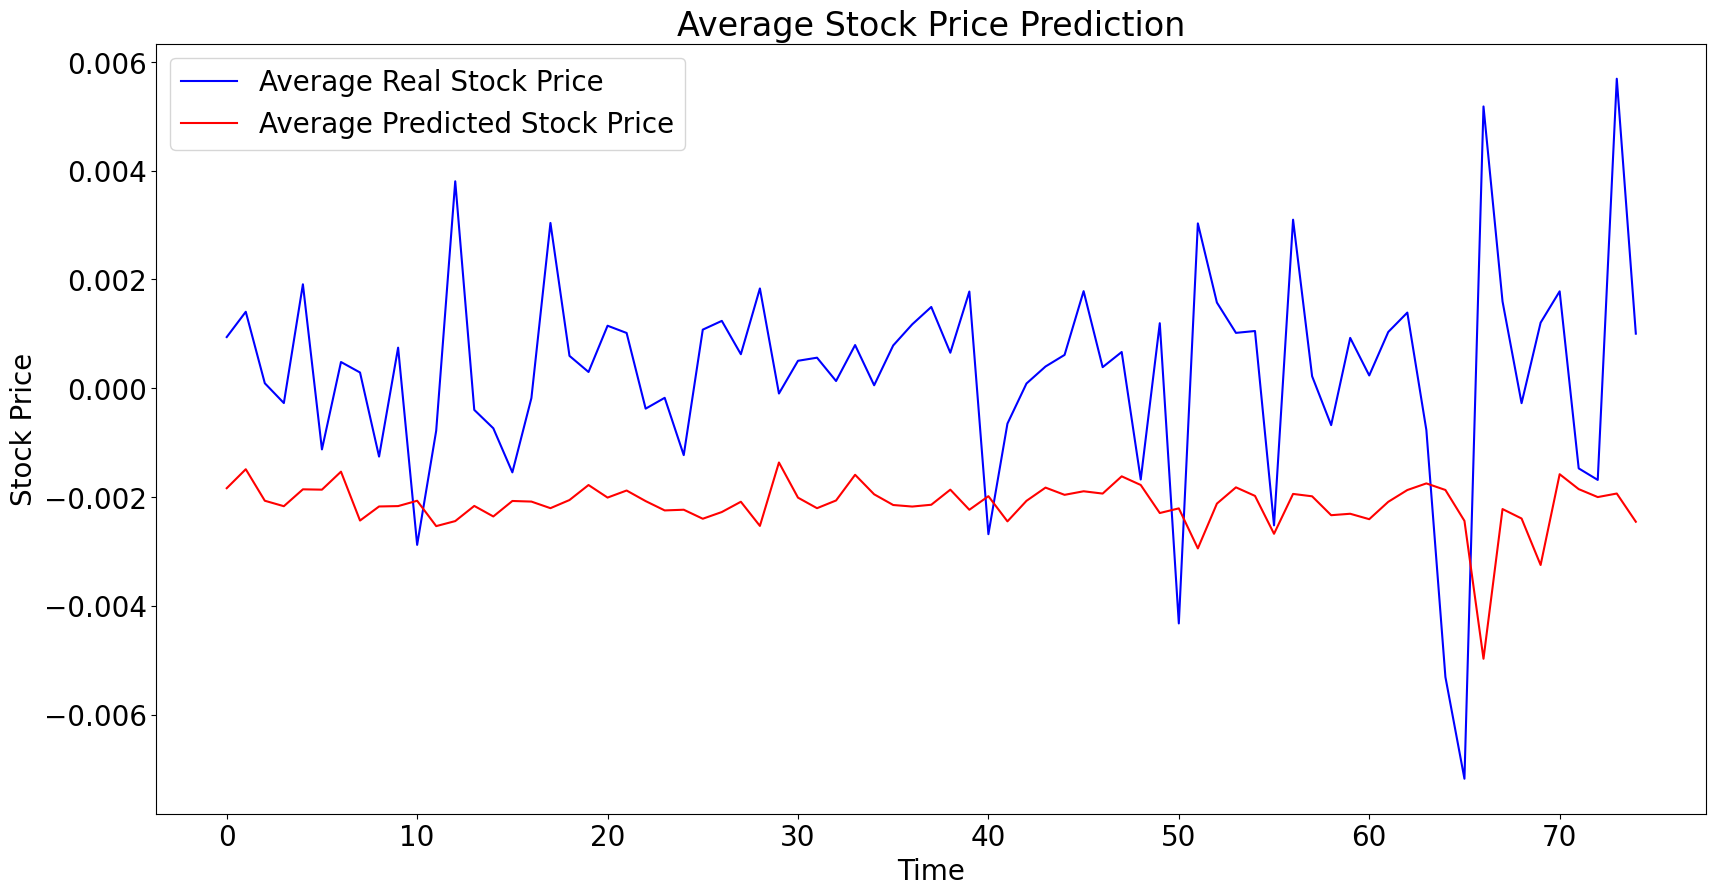

In [ ]:
# 모든 주식의 평균 예측값& 실제값 그래프 그리기

plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,10))

# 실제 데이터 그래프
avg_test_y = np.mean(test_y, axis=1)
plt.plot(avg_test_y, color='blue', label='Average Real Stock Price')

# 예측 데이터 그래프
avg_pred_y = np.mean(pred_y, axis=1)
plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price')

plt.title('Average Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
